# Forward Modeling of an Emission Spectrum

In [1]:
from exojax.spec import rtransfer as rt

In [11]:
#ATMOSPHERE                                                                     
NP=100
T0=1300.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

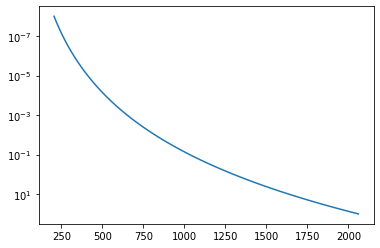

In [12]:
import matplotlib.pyplot as plt
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using nugrid.

In [13]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(22920,23000,1000,unit="AA")

Loading a molecular database of CO and CIA (H2-H2)... 

In [14]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [28]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [15]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [18]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [29]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

And line strength

In [20]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

nu matrix

In [21]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus,mdbCO.nu_lines)

Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section. 

In [30]:
from exojax.spec.lpf import xsmatrix
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

xsmatrix has the shape of (# of layers, # of nu grid)

In [36]:
import numpy as np
np.shape(xsm)

(100, 1000)

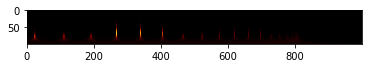

In [39]:
import numpy as np
plt.imshow(xsm,cmap="afmhot")
plt.show()

computing delta tau for CO

In [41]:
from exojax.spec.rtransfer import dtauM
g=1.e5 #gravity cm/s2
MMR=0.01 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [43]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [47]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

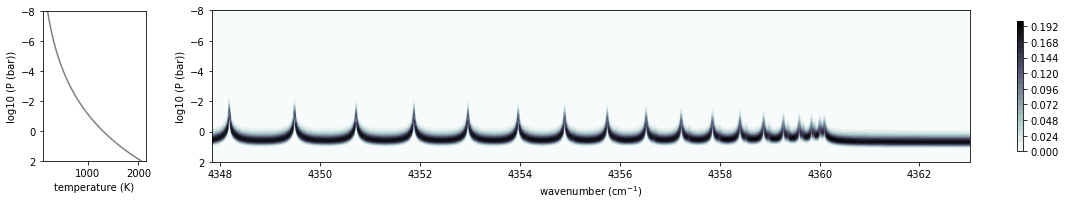

In [51]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [52]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

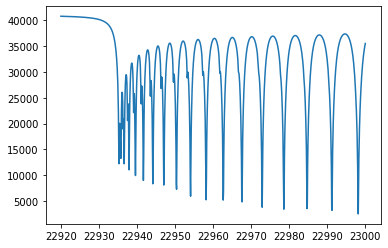

In [55]:
plt.plot(wav[::-1],F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [60]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

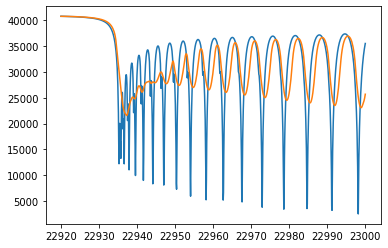

In [61]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)